In [2]:
import torch 
import argparse
import yaml
import time
import multiprocessing as mp
import torch.nn.functional as F
from tabulate import tabulate
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
#from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DistributedSampler, RandomSampler
from torch import distributed as dist
from nmc.models import *
from nmc.datasets import * 
from nmc.augmentations import get_train_augmentation, get_val_augmentation
from nmc.losses import get_loss
from nmc.schedulers import get_scheduler
from nmc.optimizers import get_optimizer
from nmc.utils.utils import fix_seeds, setup_cudnn, cleanup_ddp, setup_ddp
from tools.val import evaluate_epi
from nmc.utils.episodic_utils import * 
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from scipy.cluster import hierarchy
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from torch.utils.data import Dataset, DataLoader, Sampler


In [3]:
with open('configs/NMC.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
print(cfg)
fix_seeds(3407)
setup_cudnn()
gpu = setup_ddp()
save_dir = Path(cfg['SAVE_DIR'])
save_dir.mkdir(exist_ok=True)
cleanup_ddp()

{'DEVICE': 'cuda:1', 'SAVE_DIR': 'output', 'MODEL': {'NAME': 'FGMaxxVit', 'BACKBONE': 'FGMaxxVit', 'PRETRAINED': 'checkpoints/pretrained/maxvit_base_tf_512.in1k_pretrained_weights.pth', 'UNFREEZE': 'full', 'VERSION': 'ImageNet_APTOS_1024'}, 'DATASET': {'NAME': 'NMCDataset', 'ROOT': '/data/nmc/processed_image', 'TRAIN_RATIO': 0.7, 'VALID_RATIO': 0.15, 'TEST_RATIO': 0.15}, 'TRAIN': {'IMAGE_SIZE': [512, 512], 'BATCH_SIZE': 32, 'EPOCHS': 100, 'EVAL_INTERVAL': 25, 'AMP': False, 'DDP': False}, 'LOSS': {'NAME': 'BCEWithLogitsLoss', 'CLS_WEIGHTS': False}, 'OPTIMIZER': {'NAME': 'adamw', 'LR': 0.001, 'WEIGHT_DECAY': 0.01}, 'SCHEDULER': {'NAME': 'warmuppolylr', 'POWER': 0.9, 'WARMUP': 10, 'WARMUP_RATIO': 0.1}, 'EVAL': {'MODEL_PATH': 'checkpoints/pretrained/FGMaxxVit/FGMaxxVit.FGMaxxVit.NMC.pth', 'IMAGE_SIZE': [512, 512]}, 'TEST': {'MODEL_PATH': 'checkpoints/pretrained/FGMaxxVit/FGMaxxVit.FGMaxxVit.NMC.pth', 'FILE': 'assests/ade', 'IMAGE_SIZE': [512, 512], 'OVERLAY': True}}


In [4]:
def extract_labels(dataloader):
    all_labels = []
    for _, labels in tqdm(dataloader, desc="Extracting labels"):
        all_labels.append(labels.numpy())
    return np.vstack(all_labels)
def calculate_mutual_info_matrix(label_matrix):
    n_labels = label_matrix.shape[1]
    mi_matrix = np.zeros((n_labels, n_labels))
    for i in range(n_labels):
        for j in range(i, n_labels):
            mi = mutual_info_score(label_matrix[:, i], label_matrix[:, j])
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi
    return mi_matrix
def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap='coolwarm')
    plt.title(title)
    plt.show()
def analyze_trainloader_labels(trainloader):
    # 라벨 추출
    label_matrix = extract_labels(trainloader)

    # 상호 정보량 매트릭스 계산 및 시각화
    mi_matrix = calculate_mutual_info_matrix(label_matrix)
    plot_heatmap(mi_matrix, 'Label Mutual Information Matrix')
    return mi_matrix
def select_most_independent_labels(mi_matrix):
    linkage = hierarchy.linkage(mi_matrix, method='average')
    
    n_labels = mi_matrix.shape[0]
    ordered_labels = []
    remaining_clusters = list(range(2 * n_labels - 1))
    
    while len(ordered_labels) < n_labels:
        heights = [linkage[i-n_labels, 2] if i >= n_labels else 0 for i in remaining_clusters]
        max_height_idx = np.argmax(heights)
        selected_cluster = remaining_clusters[max_height_idx]
        
        if selected_cluster < n_labels:
            if selected_cluster not in ordered_labels:
                ordered_labels.append(selected_cluster)
            remaining_clusters.remove(selected_cluster)
        else:
            left, right = linkage[selected_cluster - n_labels, :2].astype(int)
            for child in [left, right]:
                if child < n_labels and child not in ordered_labels:
                    ordered_labels.append(child)
            remaining_clusters.remove(selected_cluster)
        
        # 모든 라벨이 선택되었다면 종료
        if len(ordered_labels) == n_labels:
            break
    
    return ordered_labels

In [5]:
start = time.time()
best_mf1 = 0.0
device = torch.device(cfg['DEVICE'])
print("device : ",device)
num_workers = mp.cpu_count()
train_cfg, eval_cfg = cfg['TRAIN'], cfg['EVAL']
dataset_cfg, model_cfg = cfg['DATASET'], cfg['MODEL']
loss_cfg, optim_cfg, sched_cfg = cfg['LOSS'], cfg['OPTIMIZER'], cfg['SCHEDULER']
epochs, lr = train_cfg['EPOCHS'], optim_cfg['LR']

image_dir = Path(dataset_cfg['ROOT']) / 'train_images'
transformations = get_train_augmentation(train_cfg['IMAGE_SIZE'])
batch_size = 32

dataset = eval(dataset_cfg['NAME'])(dataset_cfg['ROOT']+'/combined_images',dataset_cfg['TRAIN_RATIO'], dataset_cfg['VALID_RATIO'], dataset_cfg['TEST_RATIO'],  transformations)
trainset, valset, testset = dataset.get_splits()
trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, drop_last=True, pin_memory=True)
valloader = DataLoader(valset, batch_size=1, num_workers=1, pin_memory=True)
testloader = DataLoader(testset, batch_size=1, num_workers=1, pin_memory=True)

device :  cuda:1
/data/nmc/processed_image/combined_images
(0,)             148
(0, 10)          110
(10,)             56
(0, 9, 10)        41
(0, 9)            41
                ... 
(1, 8, 9, 10)      1
(3, 4, 9, 10)      1
(5,)               1
(1, 2, 9, 10)      1
(3, 4)             1
Name: label, Length: 65, dtype: int64
train size: 686
(0,)                30
(0, 10)             25
(0, 9)              10
(0, 9, 10)           8
(9, 10)              5
(2, 10)              5
(1, 2)               4
(3, 10)              3
(1, 2, 3)            3
(1, 2, 3, 8)         3
(1, 10)              3
(8, 10)              2
(2, 8, 10)           2
(1, 2, 8, 10)        2
(0, 8)               2
(1, 2, 8, 9)         2
(1, 2, 3, 8, 10)     2
(1, 9, 10)           2
(0, 8, 10)           1
(1, 2, 5, 8)         1
(1, 2, 3, 9)         1
(1, 2, 9, 10)        1
(5, 8, 9, 10)        1
(2, 9, 10)           1
(2, 4)               1
(1, 2, 3, 4)         1
(3, 9)               1
(1, 4, 9, 10)        1
(2, 3, 9)   

In [6]:
len(trainset)

686

Extracting labels: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


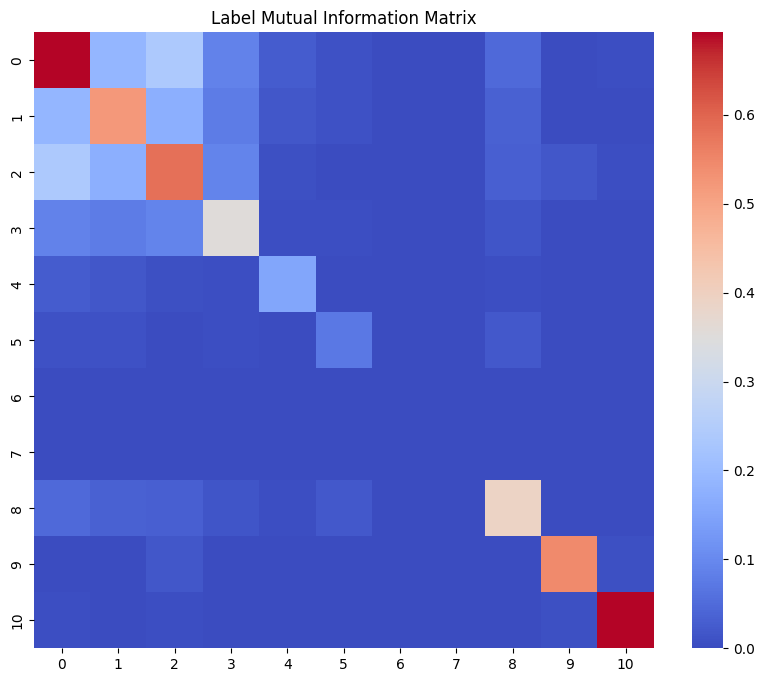

In [7]:
mi_matrix = analyze_trainloader_labels(trainloader)

In [8]:
def calculate_metrics(all_preds, all_labels):
    # PyTorch 텐서를 CPU로 이동하고 NumPy 배열로 변환
    all_preds = all_preds.cpu().numpy()
    all_labels = all_labels.cpu().numpy()
    
    # 예측값을 0 또는 1로 변환 (임계값 0.5 사용)
    pred_binary = (all_preds > 0.5).astype(int)
    
    # 실제 데이터에 존재하는 클래스 인덱스 찾기
    active_classes = np.where(np.sum(all_labels, axis=0) > 0)[0]
    
    # 전체 정확도 계산
    accuracy = accuracy_score(all_labels, pred_binary)
    
    # 각 클래스별 F1 점수, 정밀도, 재현율 계산 (활성 클래스만)
    f1_scores = f1_score(all_labels[:, active_classes], pred_binary[:, active_classes], average=None, zero_division=0)
    precision_scores = precision_score(all_labels[:, active_classes], pred_binary[:, active_classes], average=None, zero_division=0)
    recall_scores = recall_score(all_labels[:, active_classes], pred_binary[:, active_classes], average=None, zero_division=0)
    
    # Hamming Loss 계산
    hamming = hamming_loss(all_labels, pred_binary)
    
    # 샘플당 정확히 모든 라벨을 맞춘 비율 (Subset Accuracy)
    subset_accuracy = (all_labels == pred_binary).all(axis=1).mean()
    
    return {
        'accuracy': accuracy,
        'hamming_loss': hamming,
        'subset_accuracy': subset_accuracy,
        'f1_scores': f1_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'active_classes': active_classes
    }

def print_metrics(metrics):
    print("=== Overall Metrics ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Hamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"Subset Accuracy: {metrics['subset_accuracy']:.4f}")
    print("\n=== Class-wise Metrics ===")
    print("Class\t\tF1 Score\tPrecision\tRecall")
    print("-" * 50)
    for i, class_idx in enumerate(metrics['active_classes']):
        print(f"Class {class_idx}:\t{metrics['f1_scores'][i]:.4f}\t\t{metrics['precision_scores'][i]:.4f}\t\t{metrics['recall_scores'][i]:.4f}")
    
    print("\n=###############== Average Metrics (Active Classes) ==###############=")
    print(f"Macro F1: {np.mean(metrics['f1_scores']):.4f}")
    print(f"Macro Precision: {np.mean(metrics['precision_scores']):.4f}")
    print(f"Macro Recall: {np.mean(metrics['recall_scores']):.4f}")

In [9]:
class DynamicMultilabelSampler(Sampler):
    def __init__(self, labels, num_samples, batch_size, update_interval, alpha=0.7):
        self.labels = labels
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.update_interval = update_interval
        self.num_classes = labels.shape[1]
        self.alpha = alpha
        
        class_sample_count = np.sum(self.labels, axis=0)
        class_weights = np.where(class_sample_count > 0, 1. / class_sample_count, 0.)
        self.initial_class_probs = class_weights / np.sum(class_weights)
        self.class_probs = self.initial_class_probs.copy()

        self.class_losses = np.ones(self.num_classes)

    def update_class_probs(self, class_losses):
        class_losses_np = class_losses.cpu().numpy()
        normalized_losses = class_losses_np / np.sum(class_losses_np)
        self.class_probs = (self.alpha * normalized_losses + 
                            (1 - self.alpha) * self.initial_class_probs)
        self.class_probs /= np.sum(self.class_probs)

    def update_class_losses(self, class_losses):
        self.class_losses = class_losses.cpu().numpy()

    def __iter__(self):
        num_batches = self.update_interval
        all_batches = []

        # update_interval 만큼의 배치만 생성
        for _ in range(num_batches):
            batch = []
            for _ in range(self.batch_size):
                selected_class = np.random.choice(self.num_classes, p=self.class_probs)
                samples_of_class = np.where(self.labels[:, selected_class] == 1)[0]
                if len(samples_of_class) > 0:
                    selected_sample = np.random.choice(samples_of_class)
                    batch.append(selected_sample)
                else:
                    batch.append(np.random.randint(len(self.labels)))
            all_batches.append(batch)

        # 배치 간 순서 조정
        batch_losses = []
        for batch in all_batches:
            batch_loss = np.max([np.max(self.class_losses[self.labels[sample] == 1]) for sample in batch])
            batch_losses.append(batch_loss)

        # 배치를 손실 기준으로 정렬 (손실이 높은 배치가 뒤로)
        sorted_batches = [batch for _, batch in sorted(zip(batch_losses, all_batches), key=lambda x: x[0])]

        # 정렬된 배치 반환
        for batch in sorted_batches:
            yield batch

    def __len__(self):
        return self.update_interval

In [13]:
resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, dataset.n_classes)
resnet = resnet.to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
criterion_bce_cls = nn.BCEWithLogitsLoss(reduction='none')
scaler = GradScaler(enabled=train_cfg['AMP'])

train_labels = dataset.train_data[1]  # 원-핫 인코딩된 레이블

epochs = 10
update_interval = 7
total_iterations = len(train_labels) // batch_size
iterations_per_epoch = total_iterations // update_interval

sampler = DynamicMultilabelSampler(train_labels, len(train_labels), batch_size, update_interval)

for epoch in range(epochs):
    resnet.train()
    
    train_loss = 0.0
    total_class_counts = torch.zeros(dataset.n_classes, device=device)
    
    # 에포크 시작 시 이전 에포크의 avg_class_losses 사용 (첫 에포크에는 None)
    prev_avg_class_losses = None
    
    for major_iter in range(iterations_per_epoch):
        if prev_avg_class_losses is not None:
            sampler.update_class_losses(prev_avg_class_losses)
        
        class_losses = torch.zeros(dataset.n_classes, device=device)
        class_counts = torch.zeros(dataset.n_classes, device=device)
        
        trainloader = DataLoader(trainset, batch_sampler=sampler, num_workers=0)
        pbar = tqdm(enumerate(trainloader), total=update_interval, 
                    desc=f"Epoch: [{epoch+1}/{epochs}] Major Iter: [{major_iter+1}/{iterations_per_epoch}]")
        
        for iter, (img, lbl) in pbar:
            img = img.to(device)
            lbl = lbl.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            
            batch_class_counts = torch.sum(lbl, dim=0)
            total_class_counts += batch_class_counts
            class_counts += batch_class_counts
            
            with autocast(enabled=train_cfg['AMP']):
                logits = resnet(img)
                loss_per_sample = criterion_bce_cls(logits, lbl)
                loss_per_class = torch.sum(loss_per_sample * lbl, dim=0)
                class_losses += loss_per_class
                loss = loss_per_sample.mean()
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            
            pbar.set_description(f"Epoch: [{epoch+1}/{epochs}] Major Iter: [{major_iter+1}/{iterations_per_epoch}] "
                                 f"Iter: [{iter+1}/{update_interval}] Loss: {loss.item():.4f}")

        # update_interval 후 샘플링 확률 업데이트
        avg_class_losses = (class_losses / class_counts.clamp(min=1)).detach()
        prev_avg_class_losses = avg_class_losses  # 다음 major iteration을 위해 저장
        sampler.update_class_probs(avg_class_losses)

        # 클래스 통계 출력
        table_data = []
        for i in range(dataset.n_classes):
            if class_counts[i] > 0:
                distribution = class_counts[i].item()
                loss = avg_class_losses[i].item()
                sampling_prob = sampler.class_probs[i]
                table_data.append([i, f"{sampling_prob:.4f}", distribution, f"{loss:.4f}"])
        
        table = tabulate(table_data, 
                         headers=["Class","Sampling Prob", "Distribution", "Loss"],
                         tablefmt="grid", 
                         floatfmt=".4f")
        
        print(f"\nClass Statistics:")
        print(table)
        print()  # 빈 줄 추가

    train_loss /= (iterations_per_epoch * update_interval)
    
    print(f"\nEpoch {epoch+1} completed. Average loss: {train_loss:.4f}")
    print("\nTotal class distribution for this epoch:")
    for i, count in enumerate(total_class_counts.cpu().numpy()):
        print(f"Class {i}: {count}")

    # 평가 부분
    resnet.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for img, lbl in valloader:
            img = img.to(device)
            lbl = lbl.to(device)
            logits = resnet(img)    
            all_preds.append(logits)
            all_labels.append(lbl)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    metrics = calculate_metrics(all_preds, all_labels)
    print_metrics(metrics)

/root/anaconda3/envs/gm/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
Epoch: [1/10] Major Iter: [1/3] Iter: [7/7] Loss: 0.3795: 100%|██████████| 7/7 [00:59<00:00,  8.54s/it]



Class Statistics:
+---------+-----------------+----------------+--------+
|   Class |   Sampling Prob |   Distribution |   Loss |
+=========+=================+================+========+
|       0 |          0.2703 |        14.0000 | 2.3171 |
+---------+-----------------+----------------+--------+
|       1 |          0.0435 |       157.0000 | 0.2893 |
+---------+-----------------+----------------+--------+
|       2 |          0.0459 |       133.0000 | 0.3283 |
+---------+-----------------+----------------+--------+
|       3 |          0.0880 |        89.0000 | 0.5961 |
+---------+-----------------+----------------+--------+
|       4 |          0.1622 |        44.0000 | 0.8886 |
+---------+-----------------+----------------+--------+
|       5 |          0.2037 |       132.0000 | 0.3194 |
+---------+-----------------+----------------+--------+
|       8 |          0.0500 |       137.0000 | 0.2916 |
+---------+-----------------+----------------+--------+
|       9 |          0.0899 |

Epoch: [1/10] Major Iter: [2/3] Iter: [7/7] Loss: 0.3887: 100%|██████████| 7/7 [00:54<00:00,  7.75s/it]



Class Statistics:
+---------+-----------------+----------------+--------+
|   Class |   Sampling Prob |   Distribution |   Loss |
+=========+=================+================+========+
|       0 |          0.1929 |        78.0000 | 2.2065 |
+---------+-----------------+----------------+--------+
|       1 |          0.0615 |       107.0000 | 0.5991 |
+---------+-----------------+----------------+--------+
|       2 |          0.0507 |        92.0000 | 0.4958 |
+---------+-----------------+----------------+--------+
|       3 |          0.1167 |        61.0000 | 1.1367 |
+---------+-----------------+----------------+--------+
|       4 |          0.1675 |        46.0000 | 1.2563 |
+---------+-----------------+----------------+--------+
|       5 |          0.2334 |        46.0000 | 0.7766 |
+---------+-----------------+----------------+--------+
|       8 |          0.0526 |        72.0000 | 0.4223 |
+---------+-----------------+----------------+--------+
|       9 |          0.0782 |

Epoch: [1/10] Major Iter: [3/3] Iter: [7/7] Loss: 0.3396: 100%|██████████| 7/7 [00:54<00:00,  7.77s/it]


Class Statistics:
+---------+-----------------+----------------+--------+
|   Class |   Sampling Prob |   Distribution |   Loss |
+=========+=================+================+========+
|       0 |          0.1140 |        52.0000 | 1.2411 |
+---------+-----------------+----------------+--------+
|       1 |          0.0659 |       121.0000 | 0.6287 |
+---------+-----------------+----------------+--------+
|       2 |          0.0799 |       108.0000 | 0.8099 |
+---------+-----------------+----------------+--------+
|       3 |          0.1020 |        88.0000 | 0.9333 |
+---------+-----------------+----------------+--------+
|       4 |          0.1921 |        40.0000 | 1.4925 |
+---------+-----------------+----------------+--------+
|       5 |          0.2544 |        64.0000 | 0.9881 |
+---------+-----------------+----------------+--------+
|       8 |          0.0821 |        84.0000 | 0.7421 |
+---------+-----------------+----------------+--------+
|       9 |          0.0652 |

=== Overall Metrics ===
Accuracy: 0.0075
Hamming Loss: 0.3643
Subset Accuracy: 0.0075

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0000		0.0000		0.0000
Class 1:	0.3804		0.2366		0.9688
Class 2:	0.4426		0.3103		0.7714
Class 3:	0.2885		0.1744		0.8333
Class 4:	0.0526		0.0312		0.1667
Class 5:	0.0952		0.0500		1.0000
Class 8:	0.3947		0.2727		0.7143
Class 9:	0.5538		0.6207		0.5000
Class 10:	0.6479		0.6301		0.6667

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.3173
Macro Precision: 0.2585
Macro Recall: 0.6246


Epoch: [2/10] Major Iter: [1/3] Iter: [7/7] Loss: 0.3356: 100%|██████████| 7/7 [00:55<00:00,  7.91s/it]



Class Statistics:
+---------+-----------------+----------------+--------+
|   Class |   Sampling Prob |   Distribution |   Loss |
+=========+=================+================+========+
|       0 |          0.1221 |        34.0000 | 1.0297 |
+---------+-----------------+----------------+--------+
|       1 |          0.0591 |       139.0000 | 0.4264 |
+---------+-----------------+----------------+--------+
|       2 |          0.0600 |       131.0000 | 0.4520 |
+---------+-----------------+----------------+--------+
|       3 |          0.0690 |        89.0000 | 0.4324 |
+---------+-----------------+----------------+--------+
|       4 |          0.2036 |        56.0000 | 1.2541 |
+---------+-----------------+----------------+--------+
|       5 |          0.2369 |        58.0000 | 0.6111 |
+---------+-----------------+----------------+--------+
|       8 |          0.0854 |        90.0000 | 0.6019 |
+---------+-----------------+----------------+--------+
|       9 |          0.1121 |

Epoch: [2/10] Major Iter: [2/3] Iter: [7/7] Loss: 0.2865: 100%|██████████| 7/7 [00:54<00:00,  7.82s/it]



Class Statistics:
+---------+-----------------+----------------+--------+
|   Class |   Sampling Prob |   Distribution |   Loss |
+=========+=================+================+========+
|       0 |          0.1866 |        40.0000 | 1.4925 |
+---------+-----------------+----------------+--------+
|       1 |          0.0607 |       114.0000 | 0.4123 |
+---------+-----------------+----------------+--------+
|       2 |          0.0431 |       111.0000 | 0.2848 |
+---------+-----------------+----------------+--------+
|       3 |          0.1098 |        64.0000 | 0.7384 |
+---------+-----------------+----------------+--------+
|       4 |          0.1331 |        61.0000 | 0.5973 |
+---------+-----------------+----------------+--------+
|       5 |          0.2410 |        59.0000 | 0.6056 |
+---------+-----------------+----------------+--------+
|       8 |          0.0546 |        84.0000 | 0.3119 |
+---------+-----------------+----------------+--------+
|       9 |          0.0855 |

Epoch: [2/10] Major Iter: [3/3] Iter: [7/7] Loss: 0.3243: 100%|██████████| 7/7 [00:53<00:00,  7.69s/it]


Class Statistics:
+---------+-----------------+----------------+--------+
|   Class |   Sampling Prob |   Distribution |   Loss |
+=========+=================+================+========+
|       0 |          0.1655 |        70.0000 | 1.5631 |
+---------+-----------------+----------------+--------+
|       1 |          0.0697 |       111.0000 | 0.5759 |
+---------+-----------------+----------------+--------+
|       2 |          0.0567 |        95.0000 | 0.4699 |
+---------+-----------------+----------------+--------+
|       3 |          0.1361 |        76.0000 | 1.1301 |
+---------+-----------------+----------------+--------+
|       4 |          0.1637 |        34.0000 | 1.0041 |
+---------+-----------------+----------------+--------+
|       5 |          0.2204 |        47.0000 | 0.5179 |
+---------+-----------------+----------------+--------+
|       8 |          0.0427 |        76.0000 | 0.2537 |
+---------+-----------------+----------------+--------+
|       9 |          0.0911 |

=== Overall Metrics ===
Accuracy: 0.0373
Hamming Loss: 0.2090
Subset Accuracy: 0.0373

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.0750		0.7500		0.0395
Class 1:	0.4545		0.3571		0.6250
Class 2:	0.6667		0.8000		0.5714
Class 3:	0.3636		0.4000		0.3333
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.1905		0.1111		0.6667
Class 8:	0.5263		0.4167		0.7143
Class 9:	0.4615		0.5172		0.4167
Class 10:	0.6111		0.5867		0.6377

=###############== Average Metrics (Active Classes) ==###############=
Macro F1: 0.3721
Macro Precision: 0.4376
Macro Recall: 0.4449


Epoch: [3/10] Major Iter: [1/3]:   0%|          | 0/7 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [11]:
# 평가 부분은 그대로 유지
resnet.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for img, lbl in testloader:
        img = img.to(device)
        lbl = lbl.to(device)
        logits = resnet(img)    
        score = calculate_metrics(logits, lbl)
        all_preds.append(logits)
        all_labels.append(lbl)
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)
metrics = calculate_metrics(all_preds, all_labels)
print_metrics(metrics)

=== Overall Metrics ===
Accuracy: 0.1014
Hamming Loss: 0.1462
Subset Accuracy: 0.1014

=== Class-wise Metrics ===
Class		F1 Score	Precision	Recall
--------------------------------------------------
Class 0:	0.3011		0.8235		0.1842
Class 1:	0.5974		0.5897		0.6053
Class 2:	0.7097		0.6600		0.7674
Class 3:	0.4571		0.5000		0.4211
Class 4:	0.0000		0.0000		0.0000
Class 5:	0.0000		0.0000		0.0000
Class 8:	0.6809		0.6154		0.7619
Class 9:	0.6667		0.5814		0.7812
Class 10:	0.6333		0.8085		0.5205

=== Average Metrics (Active Classes) ===
Macro F1: 0.4496
Macro Precision: 0.5087
Macro Recall: 0.4491


# 러닝레이트확인

# 순서변경, 난이도에 따른 샘플 선택 도입

# 난이도 확인 후 augmentation으로 공헌?